In [1]:
import warnings; warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

2022-04-03 21:13:32.511488: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-03 21:13:32.511503: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
df = pd.read_parquet("../data/processed/outlier_removed.parquet")

GENERATE_SPEED_ANGLE = True

weather_cols = [col for col in df.columns if col.startswith(("UGRD", "VGRD"))]

df = df.set_index("forecast_dt")[["rt_plant_id", "production", *weather_cols]]

if GENERATE_SPEED_ANGLE:
    for box in ["SW", "NW", "NE", "SE"]:
        df[f"speed_{box}"] = np.sqrt(np.square(df[f"UGRD_80.m.above.ground.{box}"]) + np.square(df[f"VGRD_80.m.above.ground.{box}"]))
        df[f"angle_{box}"] = np.arctan(df[f"UGRD_80.m.above.ground.{box}"] / df[f"VGRD_80.m.above.ground.{box}"])
        
time_indices = sorted(df.index.unique())
train_ratio = 0.8
valid_ratio = 0.1

train_indices = time_indices[:int(len(time_indices) * train_ratio)]
valid_indices = time_indices[int(len(time_indices) * train_ratio):int(len(time_indices) * (train_ratio + valid_ratio))]
test_indices = time_indices[int(len(time_indices) * (train_ratio + valid_ratio)):]

train_df = df.loc[train_indices, :]
valid_df = df.loc[valid_indices, :]
test_df = df.loc[test_indices, :]

PLANTS = sorted(df.rt_plant_id.unique())

def expand_plant_dimension(df):
    n_loc = len(PLANTS)
    n_time = df.index.nunique()
    cols = [col for col in df.columns if col != "rt_plant_id"]
    n_cols = len(cols)

    df_np = np.zeros((n_time, n_loc, n_cols))
    for i, plant_id in enumerate(PLANTS):
        df_np[:, i, :] = df[df.rt_plant_id == plant_id][cols].values
    return df_np

train_df_np = expand_plant_dimension(train_df)
valid_df_np = expand_plant_dimension(valid_df)
test_df_np = expand_plant_dimension(test_df)

from sklearn.preprocessing import MinMaxScaler
from pathlib import Path

scalers = {}
for i, plant in enumerate(PLANTS):
    scalers[plant] = MinMaxScaler()
    # train_df = pd.DataFrame(scaler.fit_transform(train_df), index=train_df.index, columns=train_df.columns)
    train_df_np[:, i, :] = scalers[plant].fit_transform(train_df_np[:, i, :])
    valid_df_np[:, i, :] = scalers[plant].transform(valid_df_np[:, i, :])
    test_df_np[:, i, :] = scalers[plant].transform(test_df_np[:, i, :])
    
train_df_np = np.array(train_df_np, dtype=np.float32)
valid_df_np = np.array(valid_df_np, dtype=np.float32)
test_df_np = np.array(test_df_np, dtype=np.float32)

# valid_df[valid_df["rt_plant_id"] == PLANTS[0]].iloc[0]
# scalers[PLANTS[0]].inverse_transform(valid_df_np[0])[0]

## 2D

In [4]:
print(train_df_np.shape)

(21117, 94, 17)


In [7]:
SELECTED_PLANT = 0

SELECTED_PLANT_ID = PLANTS[SELECTED_PLANT]

columns = [col for col in train_df.columns if col != "rt_plant_id"]

train_df_pd_0 = pd.DataFrame(train_df_np[:, SELECTED_PLANT], index=train_indices, columns=columns) 
valid_df_pd_0 = pd.DataFrame(valid_df_np[:, SELECTED_PLANT], index=valid_indices, columns=columns) 
test_df_pd_0 = pd.DataFrame(test_df_np[:, SELECTED_PLANT], index=test_indices, columns=columns) 


In [229]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, valid_df=valid_df, test_df=test_df,
                 columns=None, label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.valid_df = valid_df
        self.test_df = test_df
        self.ndim = self.train_df.ndim
        assert self.ndim in [2, 3]
        if columns is None:
            columns = train_df.columns

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(columns)}
        # feature_column_indices = [v for k,v in self.column_indices.items() if k not in self.label_columns]
        # list(self.label_columns_indices.values())

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        # print(features.shape)
        if self.ndim == 2:
            # inputs = features[:, self.input_slice, :]
            # labels = features[:, self.labels_slice, :]
            inputs = features[:, self.input_slice, 1:]
            labels = features[:, self.labels_slice, :]
        else:
            inputs = features[:, self.input_slice, :, 1:]
            labels = features[:, self.labels_slice, :, :]
        if self.label_columns is not None:
            if self.ndim == 3:
                labels = tf.stack([labels[:, :, :, self.column_indices[name]] for name in self.label_columns], axis=-1)
            else:
                labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)
        # print("labels: ", labels)
        # print("inputs.shape: ", inputs.shape, "\nlabels.shape: ", labels.shape)
        if self.ndim == 3:
            inputs.set_shape([None, self.input_width, None, None])
            labels.set_shape([None, self.label_width, None, None])
        else:
            inputs.set_shape([None, self.input_width, None])
            labels.set_shape([None, self.label_width, None])
        # print("inputs.shape: ", inputs.shape, "\nlabels.shape: ", labels.shape)
        return inputs, labels

    def plot(self, model=None, plot_col='production', plant=None, max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue
            
            if self.ndim == 2:
                input_values = inputs[n, :, plot_col_index]
                label_values = labels[n, :, label_col_index]
            elif plant is not None:
                input_values = inputs[n, :, plant, plot_col_index]
                label_values = labels[n, :, plant, label_col_index]
            else:
                input_values = tf.math.reduce_mean(inputs[n, :, :, plot_col_index], axis=1)
                label_values = tf.math.reduce_mean(labels[n, :, :, label_col_index], axis=1)
                
            plt.plot(self.input_indices, input_values, label='Inputs', marker='.', zorder=-10)

                
            plt.scatter(self.label_indices, label_values, edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                if self.ndim == 2:
                    prediction_values = predictions[n, :, label_col_index]
                elif plant is not None:
                    prediction_values = predictions[n, :, plant, label_col_index]
                else:
                    prediction_values = tf.math.reduce_mean(predictions[n, :, :, label_col_index], axis=1)
                
                prediction_values = tf.clip_by_value(prediction_values, clip_value_min=0, clip_value_max=1)

                plt.scatter(self.label_indices, prediction_values,
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=24,
            shuffle=False,
            batch_size=64,)
        ds = ds.map(self.split_window)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def valid(self):
        return self.make_dataset(self.valid_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

In [230]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=10):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min', 
        verbose=1,
        restore_best_weights=True)

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()]) 
    
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.valid,
                        verbose=1,
                        callbacks=[early_stopping])
    print(model.summary())
    return history

In [231]:
OUT_STEPS = 24
num_features = 17

multi_window = WindowGenerator(
    train_df=train_df_pd_0, valid_df=valid_df_pd_0, test_df=test_df_pd_0,
    input_width=120, label_width=24, shift=0, label_columns=["production"])

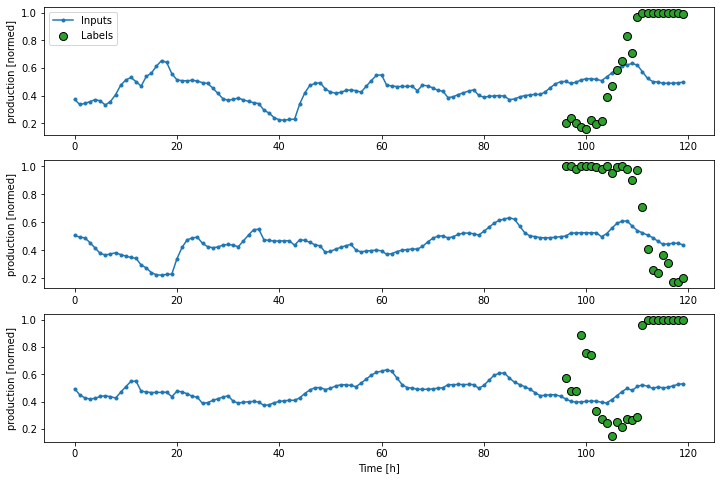

In [232]:
multi_window.plot()

In [235]:
columns = [col for col in train_df.columns if col != "rt_plant_id"]

multi_window2 = WindowGenerator(
    train_df=train_df_np, valid_df=valid_df_np, test_df=test_df_np, columns=columns,
    input_width=120, label_width=24, shift=0, label_columns=["production"])
multi_window2

Total window size: 120
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
Label indices: [ 96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119]
Label column name(s): ['production']

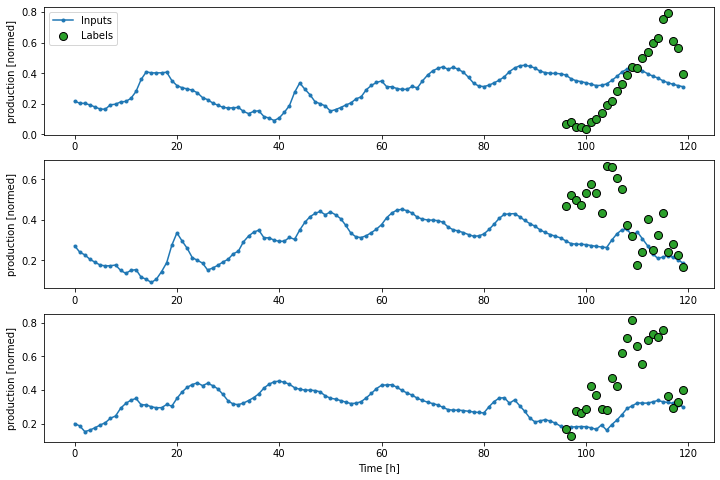

In [236]:
multi_window2.plot(plant=4)

In [237]:
multi_val_performance = {}
multi_performance = {}

## Dense

In [238]:
from tensorflow.keras import models, layers

In [239]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(120, 16)))
model.add(layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()))
model.add(layers.Flatten())
model.add(layers.Dense(OUT_STEPS))
model.add(layers.Reshape([OUT_STEPS, 1]))
model.summary()

history = compile_and_fit(model, multi_window)

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 120, 24)           408       
                                                                 
 flatten_13 (Flatten)        (None, 2880)              0         
                                                                 
 dense_37 (Dense)            (None, 24)                69144     
                                                                 
 reshape_15 (Reshape)        (None, 24, 1)             0         
                                                                 
Total params: 69,552
Trainable params: 69,552
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
14/14 [==============================] - 0s 10ms/step - loss: 0.1744 - mean_absolute_error: 0.3456 - val_loss: 0.1071 - val_mean_absolute_error: 0.2699
Epoch 2/100
14/14

In [240]:
multi_val_performance['Linear1'] = model.evaluate(multi_window.valid)
multi_performance['Linear1'] = model.evaluate(multi_window.test, verbose=0)


2/2 [==============================] - 0s 2ms/step - loss: 0.0373 - mean_absolute_error: 0.1589


In [241]:
multi_val_performance

{'Linear1': [0.03730766847729683, 0.15892842411994934]}

In [242]:
multi_performance

{'Linear1': [0.05593171343207359, 0.18736369907855988]}

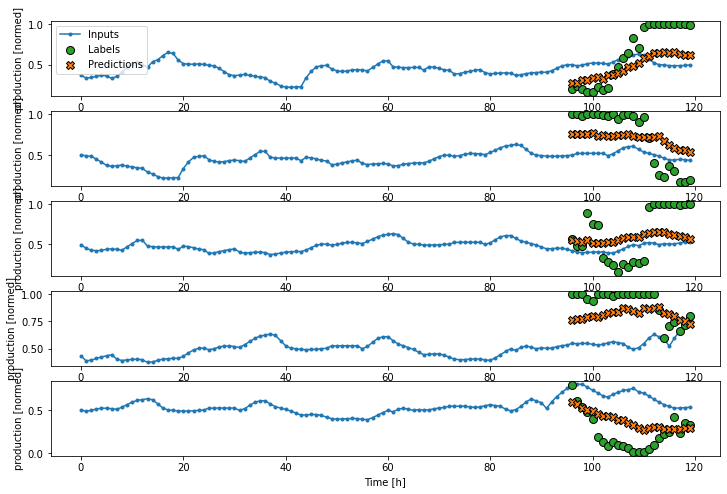

In [243]:
multi_window.plot(model, max_subplots=5)

In [245]:
predictions = model.predict(multi_window.test)
predictions[0]

array([[0.13480249],
       [0.13885595],
       [0.15528096],
       [0.13294436],
       [0.14087778],
       [0.12340248],
       [0.13333397],
       [0.11444721],
       [0.11954084],
       [0.11983488],
       [0.1269971 ],
       [0.15499902],
       [0.16494387],
       [0.21636635],
       [0.21925175],
       [0.25300518],
       [0.2605106 ],
       [0.29698545],
       [0.30838567],
       [0.2947672 ],
       [0.3012949 ],
       [0.30274957],
       [0.2772879 ],
       [0.2711351 ]], dtype=float32)

In [246]:
actual = np.concatenate([y for x, y in multi_window.test], axis=0)
actual[0]

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.02      ],
       [0.00857143],
       [0.0072    ],
       [0.02502857],
       [0.00285714],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.03862857],
       [0.07577143],
       [0.09714286],
       [0.04354286],
       [0.00148571],
       [0.        ],
       [0.01428571]], dtype=float32)

In [217]:
for i in multi_window.test:
    print(i)
    break

(<tf.Tensor: shape=(64, 120, 16), dtype=float32, numpy=
array([[[0.43766925, 0.47389206, 0.3576842 , ..., 0.66516346,
         0.27546185, 0.68531424],
        [0.42155945, 0.45165122, 0.36057812, ..., 0.6624111 ,
         0.2903231 , 0.68551743],
        [0.4224656 , 0.4293302 , 0.36741084, ..., 0.65936416,
         0.29372293, 0.6795816 ],
        ...,
        [0.13235535, 0.14911668, 0.12640372, ..., 0.7424513 ,
         0.67661214, 0.7734415 ],
        [0.1553141 , 0.16879669, 0.13155936, ..., 0.74484324,
         0.6639195 , 0.76505715],
        [0.17180414, 0.18013723, 0.15012035, ..., 0.7381456 ,
         0.64157104, 0.75604826]],

       [[0.3786413 , 0.41417968, 0.34251997, ..., 0.68324447,
         0.34478337, 0.6757316 ],
        [0.36592063, 0.37395588, 0.33097038, ..., 0.6691191 ,
         0.40418774, 0.68858653],
        [0.34747955, 0.3686662 , 0.33113867, ..., 0.6755413 ,
         0.3925825 , 0.68756944],
        ...,
        [0.5544123 , 0.53353536, 0.5025052 , ..., 0.

In [214]:
multi_window.test_df.shape

(2640, 17)

In [120]:
num_features = 17
multi_linear_model = tf.keras.Sequential([
    # tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Dense(OUT_STEPS),
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

history = compile_and_fit(multi_linear_model, multi_window)

multi_val_performance['Linear1'] = multi_linear_model.evaluate(multi_window.valid)
multi_performance['Linear1'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
# multi_window.plot(multi_linear_model)


(None, None, 17)
labels:  Tensor("stack:0", shape=(None, None, 1), dtype=float32)
inputs.shape:  (None, None, 16) 
labels.shape:  (None, None, 1)
inputs.shape:  (None, 120, 16) 
labels.shape:  (None, 24, 1)
(None, None, 17)
labels:  Tensor("stack:0", shape=(None, None, 1), dtype=float32)
inputs.shape:  (None, None, 16) 
labels.shape:  (None, None, 1)
inputs.shape:  (None, 120, 16) 
labels.shape:  (None, 24, 1)
Epoch 1/20


ValueError: in user code:

    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/site-packages/keras/engine/training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/mert/miniconda3/envs/thesis/lib/python3.9/site-packages/keras/layers/core/reshape.py", line 110, in _fix_unknown_dimension
        raise ValueError(msg)

    ValueError: Exception encountered when calling layer "reshape_3" (type Reshape).
    
    total size of new array must be unchanged, input_shape = [120, 24], output_shape = [24, 1]
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 120, 24), dtype=float32)


In [ ]:
model = models.Sequential()
model.add(layers.Reshape([94, 72, 17], input_shape=(72, 94, 17)))
model.add(layers.Dense(32, kernel_initializer=tf.initializers.zeros()))
model.add(layers.Reshape([94, 32, 72]))
model.add(layers.Dense(8))
model.add(layers.Reshape([94, 8, 32]))
model.add(layers.Dense(3))
model.add(layers.Reshape([24, 94, 1]))
model.summary()

history = compile_and_fit(model, multi_window2)

In [ ]:
multi_window2.plot(model, plant=4)

In [ ]:
model = models.Sequential()
# model.add(layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :, :], input_shape=(72, 94, 17)))
# model.add(layers.Conv1D(64, CONV_WIDTH, activation='relu', input_shape=(24, 94, 17), padding="same"))
# model.add(layers.MaxPooling2D((1, 1)))
model.add(layers.Dense(64, kernel_initializer=tf.initializers.zeros(), input_shape=(72, 94, 17)))
model.add(layers.Reshape([94, 24, 64 * 3]))
model.add(layers.Dense(OUT_STEPS))
model.add(layers.Dense(1))
# model.add(layers.Flatten())
# model.add(layers.Reshape([94, 24*CONV_WIDTH]))
# model.add(layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()))
model.add(layers.Reshape([24, 94, 1]))
model.summary()

In [ ]:
history = compile_and_fit(model, multi_window2)

In [ ]:
multi_window2.plot(model, plant=10, max_subplots=10)

In [ ]:
# multi_linear_model.predict(multi_window.train)[0].shape

In [ ]:
# multi_linear_model.summary()

In [ ]:
multi_linear_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

multi_val_performance['Linear2'] = multi_linear_model.evaluate(multi_window.valid)
multi_performance['Linear2'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)


## Convolutional

In [ ]:
multi_window2.train_df.shape

In [ ]:
from tensorflow.keras import datasets, layers, models

CONV_WIDTH = 3
model = models.Sequential()
model.add(layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :, :], input_shape=(72, 94, 17)))
model.add(layers.Conv1D(64, CONV_WIDTH, activation='relu', input_shape=(24, 94, 17), padding="same"))
model.add(layers.MaxPooling2D((1, 1)))
model.add(layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()))
model.add(layers.Flatten())
model.add(layers.Reshape([94, 24*CONV_WIDTH]))
model.add(layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()))
model.add(layers.Reshape([24, 94, 1]))


# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.summary()


In [ ]:
history = compile_and_fit(model, multi_window2)

In [ ]:
multi_val_performance['Conv1'] = model.evaluate(multi_window2.valid)
multi_performance['Conv1'] = model.evaluate(multi_window2.test, verbose=0)
multi_window2.plot(model)

In [ ]:
multi_val_performance = {}
multi_performance = {}

In [ ]:
multi_window2.plot(model)

In [ ]:
multi_window2.plot(model, plant=0)

In [ ]:
multi_window2.plot(model, plant=4)

In [ ]:
multi_window2.plot(model, plant=0, max_subplots=5)

In [ ]:
from tensorflow.keras import datasets, layers, models

model = models.Sequential()
model.add(layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :, :], input_shape=(10000, 94, 17)))
# model.add(layers.Conv2D(32, (7, 7), activation='relu', input_shape=(7, 94, 17), padding="same"))
model.add(layers.Conv2D(32, (7, 7), activation='relu', input_shape=(7, 94, 17), padding="valid"))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.summary()


In [ ]:
CONV_WIDTH = 7
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)
multi_val_performance['Conv1'] = multi_conv_model.evaluate(multi_window.valid)
multi_performance['Conv1'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

In [ ]:
CONV_WIDTH = 7
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH), padding="same"),
    tf.keras.layers.Conv1D(64, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)
multi_val_performance['Conv2'] = multi_conv_model.evaluate(multi_window.valid)
multi_performance['Conv2'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

In [ ]:
CONV_WIDTH = 12
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH), padding="same"),
    tf.keras.layers.Conv1D(64, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)
multi_val_performance['Conv3'] = multi_conv_model.evaluate(multi_window.valid)
multi_performance['Conv3'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

In [ ]:
CONV_WIDTH = 24
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # tf.keras.layers.Conv1D(16, activation='relu', kernel_size=(CONV_WIDTH), padding="same"),
    # tf.keras.layers.Conv1D(16, activation='relu', kernel_size=(CONV_WIDTH), padding="same"),
    tf.keras.layers.Conv1D(1024, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)
multi_val_performance['Conv4'] = multi_conv_model.evaluate(multi_window.valid)
multi_performance['Conv4'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

In [ ]:
CONV_WIDTH = 24
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Conv1D(128, activation='relu', kernel_size=(CONV_WIDTH), padding="same"),
    tf.keras.layers.Conv1D(128, activation='relu', kernel_size=(CONV_WIDTH), padding="same"),
    tf.keras.layers.Conv1D(64, activation='relu', kernel_size=(CONV_WIDTH)), 
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)
multi_val_performance['Conv4'] = multi_conv_model.evaluate(multi_window.valid)
multi_performance['Conv4'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

## RNN

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

multi_val_performance['RNN1'] = multi_lstm_model.evaluate(multi_window.valid)
multi_performance['RNN1'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)


In [ ]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

multi_val_performance['RNN2'] = multi_lstm_model.evaluate(multi_window.valid)
multi_performance['RNN2'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)


In [ ]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

multi_val_performance['RNN3'] = multi_lstm_model.evaluate(multi_window.valid)
multi_performance['RNN3'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)


In [ ]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(16, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

multi_val_performance['RNN4'] = multi_lstm_model.evaluate(multi_window.valid)
multi_performance['RNN4'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)


In [ ]:
CONV_WIDTH = 12
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Conv1D(128, activation='relu', kernel_size=(CONV_WIDTH), padding="same"),
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

multi_val_performance['ConvLSTM1'] = multi_conv_model.evaluate(multi_window.valid)
multi_performance['ConvLSTM1'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

In [ ]:
CONV_WIDTH = 12
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Conv1D(128, activation='relu', kernel_size=(CONV_WIDTH), padding="same"),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Conv1D(32, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.LSTM(16, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

multi_val_performance['ConvLSTM2'] = multi_conv_model.evaluate(multi_window.valid)
multi_performance['ConvLSTM2'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

In [ ]:
def plot_metrics(sort_test=True):
    plt.figure(figsize=(12, 15))
    x = np.arange(len(multi_performance))
    width = 0.3
    
    for n in range(len(multi_linear_model.metrics_names)):
        plt.subplot(len(multi_linear_model.metrics_names), 1, n+1)
        metric_name = multi_linear_model.metrics_names[n]
        val_mae = [v[n] for v in multi_val_performance.values()]
        test_mae = [v[n] for v in multi_performance.values()]
        
        if sort_test:
            sorted_index = np.argsort(test_mae)
        else:
            sorted_index = np.argsort(val_mae)
        val_mae = [val_mae[i] for i in sorted_index]
        test_mae = [test_mae[i] for i in sorted_index]

        plt.bar(x - 0.17, val_mae, width, label='Validation')
        plt.bar(x + 0.17, test_mae, width, label='Test')
        plt.xticks(ticks=x, labels=[list(multi_performance.keys())[i] for i in sorted_index], rotation=45)
        plt.ylabel(metric_name)
        plt.title(metric_name)
        if n == 0:
            _ = plt.legend()

In [ ]:
plot_metrics()

In [ ]:
plot_metrics(False)

In [ ]:
multi_performance